<font size="5"> <div align="center">Calculate Angle of True North for a given Location and Projected Coordinate System</div></font>
<font size="4"> <div align="center">Cookbook Instructions</div></font>
<font size="3"> <div align="center"><strong>for Python™</strong></div></font>

The numeric method used here is independent of PYPRØJ/PROJ versions or coordinate reference systems (CRS) and returns the correct azimuth for true north for any given location in a projected coordinate system. The angle is needed to plot North arrows on maps in projected coordinate reference systems.

### STEP 1: Import requierd packages & libraries and set processing parameters

In [1]:
# import required packages & libraries and set processing parameters

# system utilities and data handling
import os
import sys
import math
import earthaccess
import numpy as np
from   pathlib import Path

# coordinate transformations and raster files
import rasterio
from   rasterio.plot import reshape_as_image
from   PIL import Image
from   pyproj import Transformer

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import matplotlib.patheffects as fx

# set font to Arial for all objects
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

### Step 2: Download CAMBOT L1B frame/granulefrom S3 link on Amazon Web Services (AWS) cloud

In [2]:
# locate a single CAMBOT L1B frame/granule and get S3 link on Amazon Web Services (AWS) cloud

t_str = '2019-05-12 19:39:40' # Kangerlussuaq ramp NS pass

# authenticate. will only prompt for login credentials if .netrc (or _netrc on Windows) is not found or has wrong permissions.
# to force the use of .netrc if it exists and has proper permissions (chmod 600 ~/.netrc) use:
# auth = earthaccess.login(strategy="netrc")
auth = earthaccess.login()

results_cam = earthaccess.search_data( short_name='IOCAM1B', cloud_hosted=True, temporal=(t_str,t_str), count=1 )

data_links = [granule.data_links(access="direct") for granule in results_cam]
s3_url_cam = data_links[0][0] # is a nested list

local_data_folder_cam = r'./data/example_files'
f_name_short_cam = f_name_short = Path(s3_url_cam).name
f_name_local_cam = Path(local_data_folder_cam) / f_name_short_cam

# download the file if it does not already exist locally
if os.path.exists(f_name_local_cam):
    print(f"✅ File already exists locally: {f_name_short_cam} --> Skipping download.")
else:
    print(f"⬇️ Downloading: {f_name_short_cam}")
    files = earthaccess.download(results_cam, local_path=local_data_folder_cam)

⬇️ Downloading: IOCAM1B_2019_GR_NASA_20190512-193940.4219.tif


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

### Step 3: Import RGB GeoTIFF image

In [3]:
# import RGB GeoTIFF image and get the parameters needed for plotting and projecting angles and data points

with rasterio.open(f_name_local_cam) as src:
    rgb_image = reshape_as_image(src.read())
    crs       = src.crs           # coordinate reference system
    nodata    = src.nodata        # "None" in this case. No data value is 0 for CAMBOT L1B data products (but not set properly as nodata value)
    bbox      = src.bounds        # returns BoundingBox object: left, bottom, right, top
    epsg_code = src.crs.to_epsg() # EPSG projection code as integer needed for axis labels

if nodata is None:
    mask = np.all(rgb_image == [0, 0, 0], axis=-1)
    # replace all nodata pixels with white for plotting
    rgb_image[mask] = [255, 255, 255]

# calculate center of the GeoTIFF bounding box in projected coordinates used for true north calculation
x_center = (bbox.left + bbox.right) / 2
y_center = (bbox.top + bbox.bottom) / 2

# set up extent array for plotting
extent_m  = [bbox.left, bbox.right, bbox.bottom, bbox.top]

### Step 4: Check if CRS is a projected map projection

In [4]:
# check if CRS is projected and setup coordinate transformations

if crs.is_projected:
    # define transformation between projected and geographic CRS
    xy2ll = Transformer.from_crs(crs, 4326, always_xy=True)
    ll2xy = Transformer.from_crs(4326, crs, always_xy=True)
elif crs.is_geographic:
    print("CRS is a geographic coordinata system, but projected is required to run this code. Abort.")
    sys.exit("CRS is a geographic coordinata system, but projected is required to run this code. Abort.")

### Step 5: Calculate angle of true north for any given location and map projection

In [5]:
# helper function for calculating angle of true north for any given location and map projection

def angle_true_north_in_xy(crs_proj, x0, y0, delta_deg=1e-5):

    """
    Purpose:  Calculate the azimuth of true north in projected coordinates.
              The azimuth is the angle of true north relative to the projected Y-axis of the CRS.
    Approach: Create a second data point in geographic coordinates north of the location to calculate azimuth

    Parameters:
    -crs_proj : coordinate reference system object from PYPRØJ, typically obtained from GeoTIFF raster
    -x0       : float64. typically center x coordinate of the GeoTIFF raster in projected coordinates from STEP 1
    -y0       : float64. typically center y coordinate of the GeoTIFF raster in projected coordinates from STEP 1
    -delta_deg: float64. Small distance for creating a seconda data point north of the location (optional).
                The default distance is 1e-5 degrees, which is ≈ 1 meter in latitude and works for most cases.

    Returns    : float64. angle of true north relative to projected Y-axis.
    """

    # convert given x and y coordinates to geographic (lat, lon)
    lon0, lat0 = xy2ll.transform(x0, y0)

    # create a second point north of it at +delta_deg° latitude for azimuth determination
    lon1, lat1 = lon0, lat0 + delta_deg
    x1, y1 = ll2xy.transform(lon1, lat1)

    # sides of rectangular triangle needed for trigonometric calculation of the azimuth
    dx = x1 - x0 # should both be positive in northern hemisphere
    dy = y1 - y0

    return math.degrees(math.atan2(dx, dy)), x1, y1 # angle of true north relative to projected Y-axis

# execute function
angle_center, x1, y1 = angle_true_north_in_xy(crs, x_center, y_center)
print(f"Azimuth angle of true north at raster center: {angle_center:.2f}°") # sign convention is consistent with QGIS

Azimuth angle of true north at raster center: 5.70°


### Step 6: Helper functions for plotting North arrows and scale bars on maps

In [6]:
# helper function for placing objects like north arrows and scale bars on map

def placing(position="ll",sep_dist_perc=3.5, bbox=bbox):
    
    """
        determines x and y coordinates in projected coordinates based on 
        desired corner and distance from x and y axes
    """
    
    # validate input parameters
    
    valid_positions = {"ul", "ur", "lr", "ll"}
    
    if position not in valid_positions:
        raise ValueError(f"Invalid position '{position}'. Must be one of the four corners: {valid_positions}")
    
    if not isinstance(sep_dist_perc, (int, float)):
        raise TypeError(f"Expected a number, got {type(sep_dist_perc).__name__}")
    elif isinstance(sep_dist_perc, int):
        sep_dist_perc = float(sep_dist_perc) # convert to float if it's an int

    if not (0 <= sep_dist_perc <= 100): # check range
        raise ValueError(f"Value {sep_dist_perc} must be between 0% and 100%.")
    
    # determine separation distance in projected coordinates based on longer axis
    dx = abs(bbox.right - bbox.left)
    dy = abs(bbox.top - bbox.bottom)    
    sep_dist = max([dx, dy]) * (sep_dist_perc)/100
    
    if position == "ll":
        x = bbox.left   + sep_dist
        y = bbox.bottom + sep_dist
    elif position == "lr":
        x = bbox.right  - sep_dist
        y = bbox.bottom + sep_dist
    elif position == "ur":
        x = bbox.right  - sep_dist
        y = bbox.top    - sep_dist
    elif position == "ul":
        x = bbox.left   + sep_dist
        y = bbox.top    - sep_dist

    return x, y

# helper function that calculates start and end coordinates for north arrow based on azimuth, length and position

def n_arrow(azimuth_degrees,position="ll",length=100):
    
    """
    calculate x and y components of a north arrow.
    length: Length of the north arrow in meters
    azimuth_degrees: azimuth angle in degrees (0° = North, clockwise positive)
    """
    
    x, y = placing(position)
    
    azimuth_radians = math.radians(azimuth_degrees)
    
    # calculate arrow components in map coordinates:
    x_component = length * math.sin(azimuth_radians)  
    y_component = length * math.cos(azimuth_radians)
    
    if position == "ll":
        xns = x
        yns = y
        xne = x + x_component
        yne = y + y_component
    elif position == "lr":
        xns = x - x_component
        yns = y
        xne = x 
        yne = y + y_component
    elif position == "ur":
        xns = x - x_component
        yns = y - y_component
        xne = x 
        yne = y
    elif position == "ul":
        xns = x 
        yns = y - y_component
        xne = x + x_component
        yne = y
    
    return xns, yns, xne, yne

# helper function for plotting north arrows

def plot_n_arrow(ax,position):
    
    xns, yns, xne, yne = n_arrow(angle_center,position)
    
    # north arrow and label
    ax.annotate("",xy = (xne, yne), xycoords='data',
        xytext=(xns, yns), textcoords='data',size=35, va="center", ha="center",
        arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.0",fc='w',lw = 1.0,ec = "black"),zorder = 5000);

    ax.plot((xne + xns)/2, (yne + yns)/2, 'wo', ms = 20, lw=3, mec='k',zorder = 5100)
    ax.text((xne + xns)/2, (yne + yns)/2, "N", fontsize = 'xx-large',font = 'Arial',fontweight = 'bold',
        rotation= -angle_center, rotation_mode='anchor', ha='center', va='center_baseline', color = 'k',zorder = 5200);

# helper function for plotting scale bars

def plot_scale_bar(ax,position='ll',length=100,space_m=10):
        
    x, y = placing(position)
    
    if position == "ll":
        xs = x
        xe = x + length
        ya = y + space_m
    elif position == "lr":
        xs = x - length
        xe = x 
        ya = y + space_m
    elif position == "ur":
        xs = x - length
        xe = x 
        ya = y - space_m
    elif position == "ul":
        xs = x 
        xe = x + length
        ya = y - space_m                                  
    
    scale_bar, = ax.plot([xs, xe], [y, y])
    plt.setp(scale_bar, color='k', linewidth = 5.0,solid_capstyle ='butt')
    scale_bar.set_path_effects([fx.Stroke(linewidth=5.0, foreground='0.0'),fx.Normal()])
    scale_bar_txt = ax.text((xs + xe)/2 , ya, f"{length:.0f} m",
            fontsize='large',font = 'Arial',fontweight = 'bold', ha = 'center', va='center_baseline', color = 'k')
    scale_bar_txt.set_path_effects([fx.Stroke(linewidth=1.5, foreground='1.0'),fx.Normal()])

### Step 7: Plot aerial image with North arrow and scale bar at desired locations

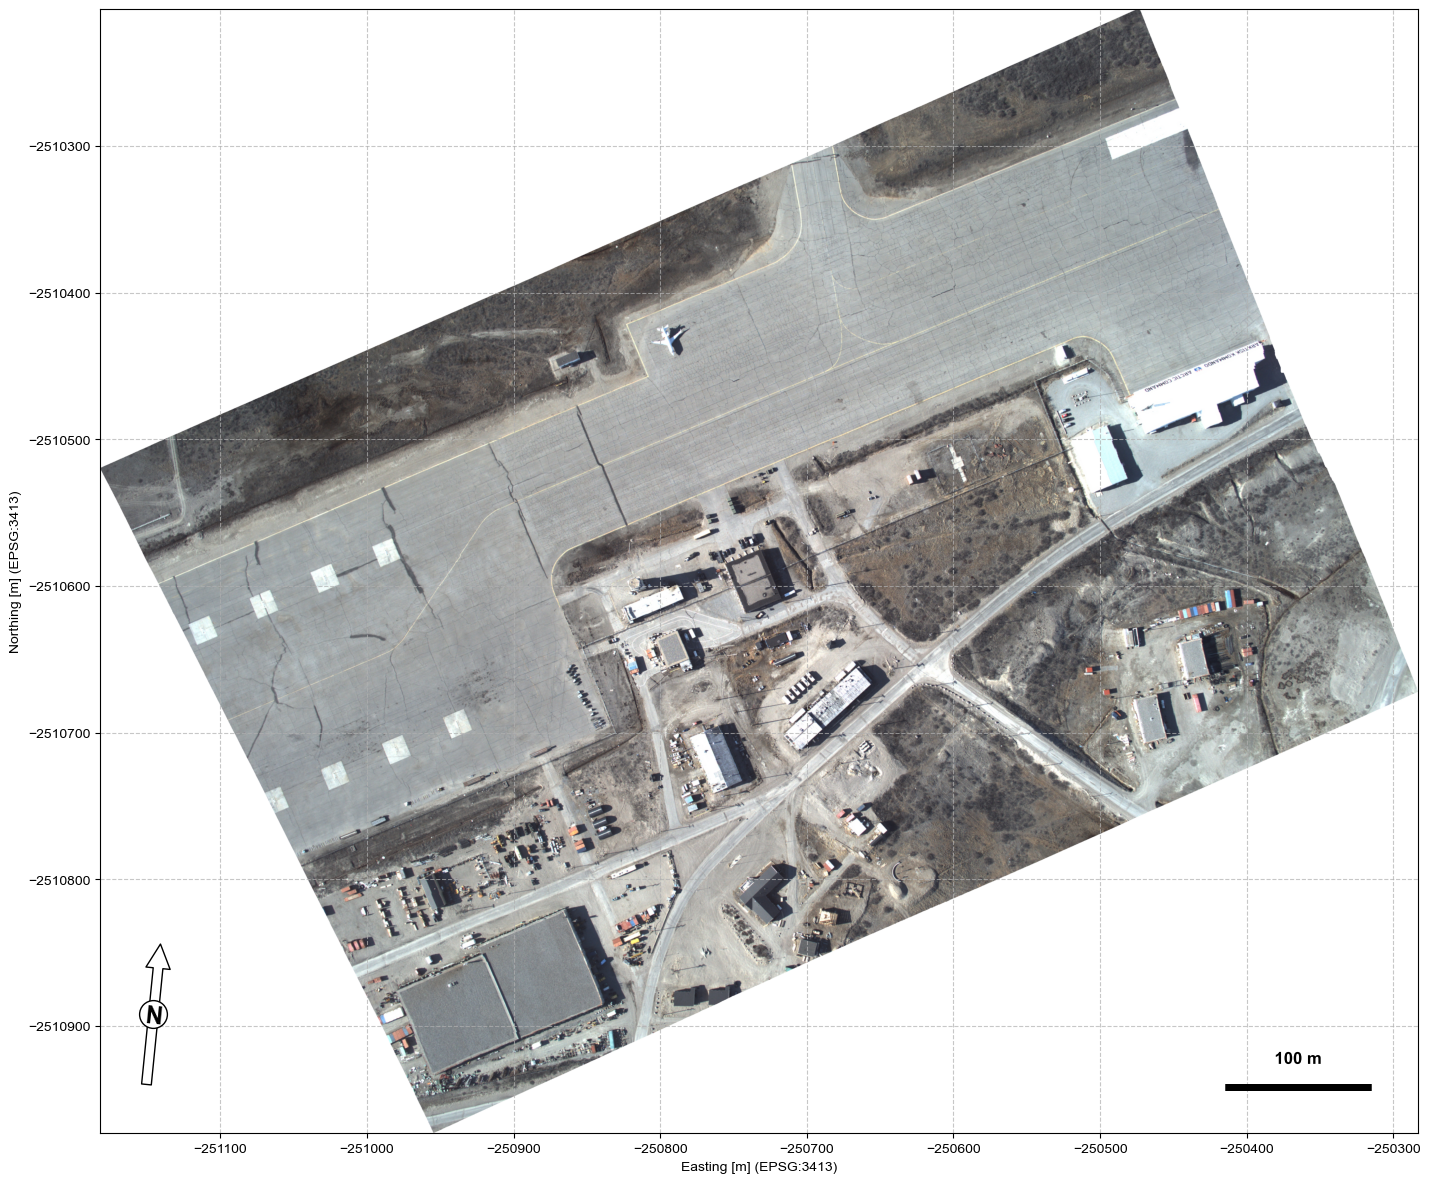

In [7]:
fig, ax = plt.subplots(figsize=(17, 15))
ax.imshow(rgb_image, extent=extent_m, origin='upper')
ax.set_xlabel(f"Easting [m] (EPSG:{epsg_code:d})")
ax.set_ylabel(f"Northing [m] (EPSG:{epsg_code:d})")

plot_n_arrow(ax,'ll')
plot_scale_bar(ax,'lr',100,20)

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))

# set grid intervals
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))

# add the grid
ax.grid(True, linestyle='--', alpha=0.7)

### Step 8: Plot similar map created with QGIS for comparison

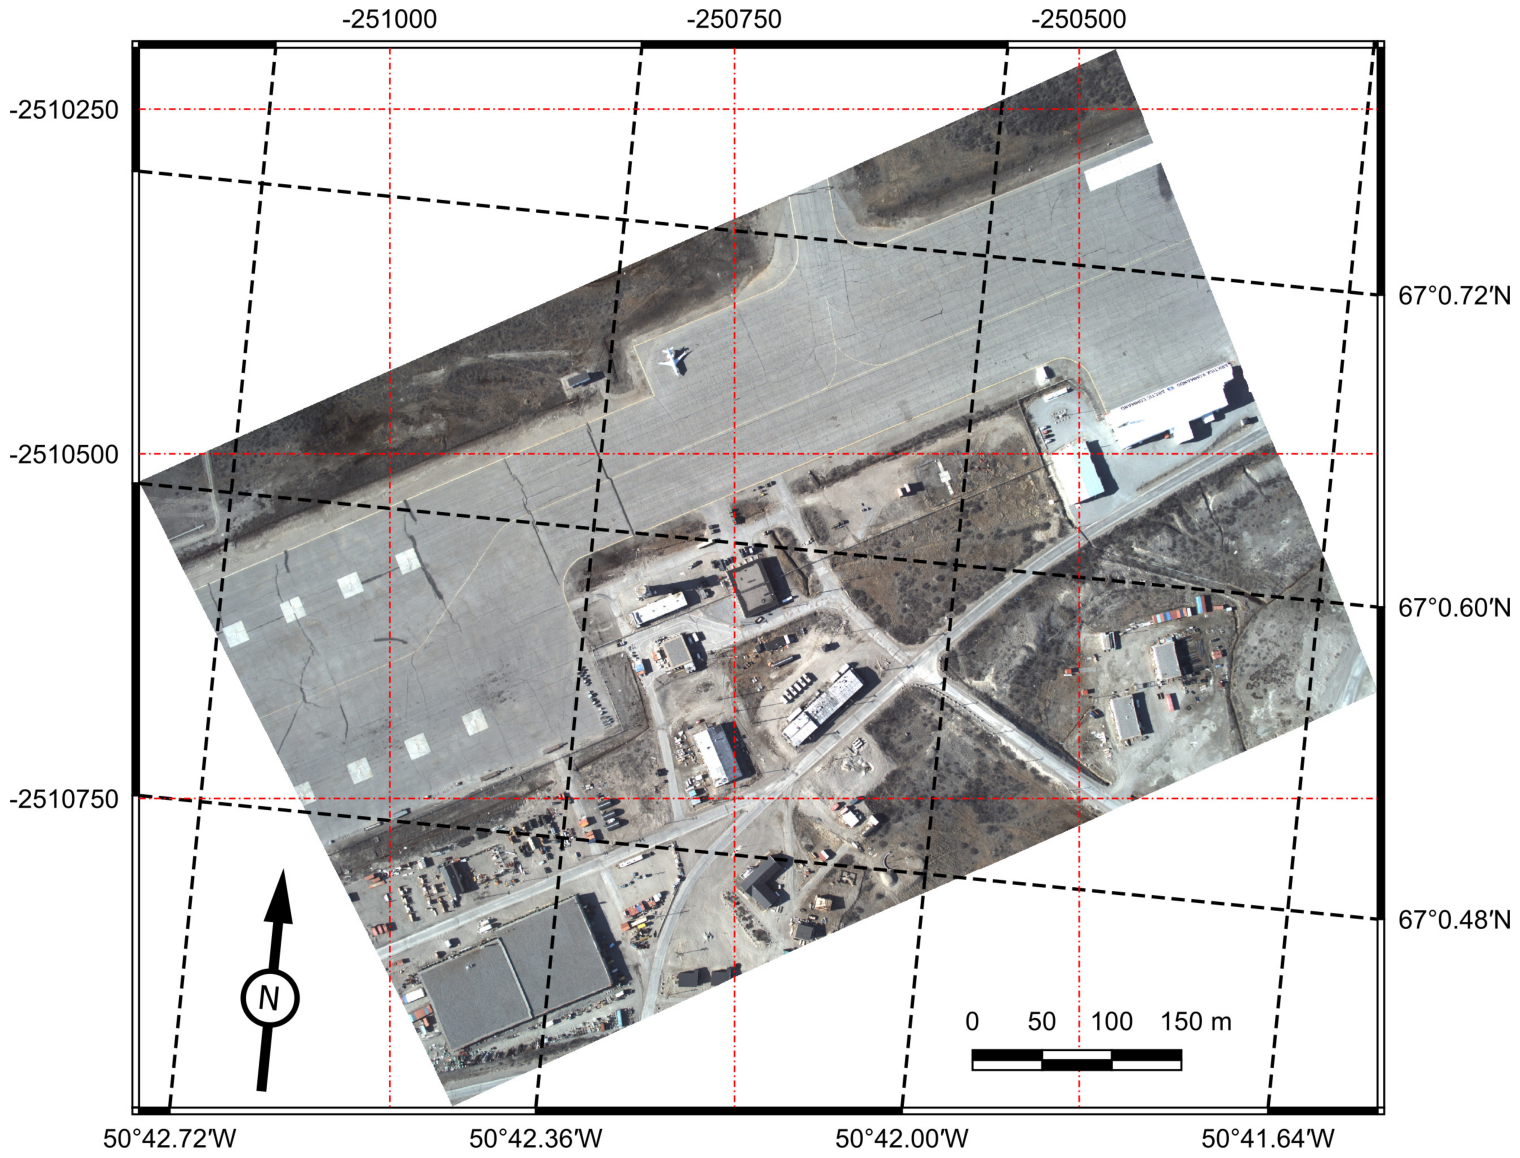

In [8]:
# load and display the image, centered and spanning from left to right
img = Image.open(r'../data/imagery/Kanger_ramp_north_arrow.jpg')
width, height = img.size
aspect_ratio = width / height
fig_width = 15
fig_height = fig_width / aspect_ratio
plt.figure(figsize=(fig_width, fig_height))
plt.imshow(img); plt.axis('off'); plt.tight_layout(pad=0); plt.show()